* has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
* total RF must be more than 44
* one of the layers must use Depthwise Separable Convolution
* one of the layers must use Dilated Convolution
* use GAP (compulsory):- add FC after GAP to target #of classes (optional)
* use albumentation library and apply:
* horizontal flip
* shiftScaleRotate
* coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
* achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.
* make sure you're following code-modularity (else 0 for full assignment) 

In this notebook we will try using torchvision transformers and in next we will try using albumentations library for data augmentation.

In [1]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
# !pip install portalocker
# !pip install torchview
# !pip install torcheval
# !pip install scikit-plot

## Helpers and Utils

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau,
    StepLR,
    OneCycleLR,
    ExponentialLR,
)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns
import torch.nn.functional as F

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    labels,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    legend_font=5,
    fig_size=(16, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(
            x_train,
            train_loss[i],
            linestyle="-",
            color="tab:{}".format(colors[i]),
            label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]),
        )
        plt.plot(
            x_val,
            val_loss[i],
            linestyle="--",
            color="tab:{}".format(colors[i]),
            label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]),
        )

    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc, prop={"size": legend_font})
    plt.title("Training and Validation Loss")

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color="tab:{}".format(colors[i]),
            label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]),
        )
        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color="tab:{}".format(colors[i]),
            label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]),
        )

    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc, prop={"size": legend_font})
    plt.title("Training and Validation Accuracy")

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time


def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f"Function Took {total_time:.4f} seconds")
        return result

    return timeit_wrapper

In [28]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Dataloader and pre-processing using torchvision tansforms

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),  # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    ]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

In [10]:
# downloading train and test data
train = datasets.CIFAR10(
    "./data", train=True, download=True, transform=train_transforms
)
test = datasets.CIFAR10("./data", train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    if device.type == "cuda"
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [12]:
# Specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [13]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([128, 3, 32, 32])
torch.Size([128])


In [14]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

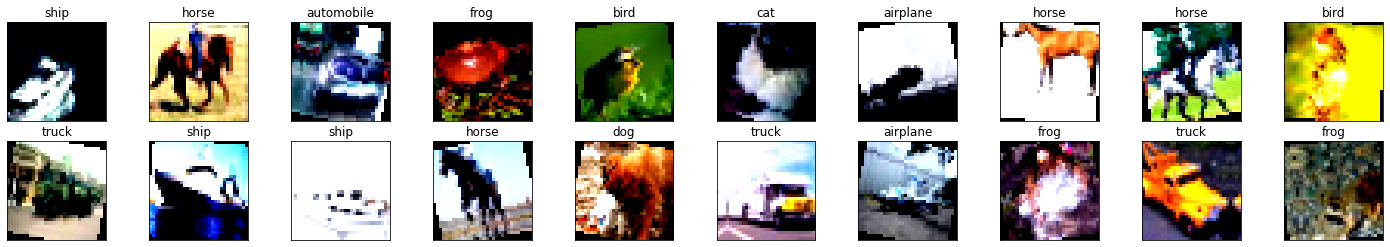

In [15]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Model Building using dialated convolution and depthwise separable convolution

### First we will build the model basis Dialated Convolution with:
* 4 conv blocks and dialated ones at last cnn layer 
* one gap and last 1*1 classification layer

In [16]:
class DialatedClassification(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_units,
        out_channels,
        multiplier_1=1,
        multiplier_2=2,
        dropout=0.1,
    ):
        super(DialatedClassification, self).__init__()
        # Convolution Block 1
        self.conv_bl1 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )
        # Convolution Block 2
        self.conv_bl2 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )
        # Convolution Block 3
        self.conv_bl3 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )
        # Convolution Block 4
        self.conv_bl4 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -non-dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=1,  # this cannot have dialation of 2 as just before output layer
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=out_channels,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            )
        )

    def forward(self, x):
        x = self.conv_bl1(x)
        x = self.conv_bl2(x)
        x = self.conv_bl3(x)
        x = self.conv_bl4(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [17]:
# New Model Instance
baseline_model_1 = DialatedClassification(
    in_channels=3, hidden_units=16, out_channels=10, multiplier_1=2, multiplier_2=4
).to(device)
summary(baseline_model_1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 30, 30]          18,432
             ReLU-10           [-1, 32, 30, 30]               0
      BatchNorm2d-11           [-1, 32, 30, 30]              64
          Dropout-12           [-1, 32, 30, 30]               0
           Conv2d-13           [-1, 32, 30, 30]           9,216
      BatchNorm2d-14           [-1, 32,

In [18]:
# updated training module---
@timeit
def train_module(
    model: torch.nn.Module,
    device: torch.device,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    metric,
    train_losses: list,
    train_metrics: list,
):

    # setting model to train mode
    model.train()
    pbar = tqdm(train_dataloader)

    # batch metrics
    train_loss = 0
    train_metric = 0
    processed_batch = 0

    for idx, (data, label) in enumerate(pbar):
        # setting up device
        data = data.to(device)
        label = label.to(device)

        # forward pass output
        preds = model(data)

        # calc loss
        loss = criterion(preds, label)
        train_loss += loss.item()
        # print(f"training loss for batch {idx} is {loss}")

        # backpropagation
        optimizer.zero_grad()  # flush out  existing grads
        loss.backward()  # back prop of weights wrt loss
        optimizer.step()  # optimizer step -> minima

        # metric calc
        preds = torch.argmax(preds, dim=1)
        # print(f"preds:: {preds}")
        metric.update(preds, label)
        train_metric += metric.compute().detach().item()

        # updating batch count
        processed_batch += 1

        pbar.set_description(
            f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}"
        )

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    train_losses.append(train_loss / processed_batch)
    train_metrics.append(train_metric / processed_batch)

    return train_losses, train_metrics

In [19]:
# updated testing modules---
@timeit
def test_module(
    model: torch.nn.Module,
    device: torch.device,
    test_dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    metric,
    test_losses,
    test_metrics,
):
    # setting model to eval mode
    model.eval()
    pbar = tqdm(test_dataloader)

    # batch metrics
    test_loss = 0
    test_metric = 0
    processed_batch = 0

    with torch.inference_mode():
        for idx, (data, label) in enumerate(pbar):
            data, label = data.to(device), label.to(device)
            # predictions
            preds = model(data)
            # print(preds.shape)
            # print(label.shape)

            # loss calc
            loss = criterion(preds, label)
            test_loss += loss.item()

            # metric calc
            preds = torch.argmax(preds, dim=1)
            metric.update(preds, label)
            test_metric += metric.compute().detach().item()

            # updating batch count
            processed_batch += 1

            pbar.set_description(
                f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}"
            )

        # It's typically called after the epoch completes
        metric.reset()
        # updating epoch metrics
        test_losses.append(test_loss / processed_batch)
        test_metrics.append(test_metric / processed_batch)

    return test_losses, test_metrics

In [20]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)
# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer, gamma=0.8)

In [21]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        baseline_model_1,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        baseline_model_1,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )
    lr_scheduler.step()  # lr scheduler stepping
    print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")
    early_stopping(
        test_losses[-1], baseline_model_1, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


Avg Train Loss: 2.3158122409473765 Avg Train Metric: 0.11201852085915479:   3%|████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 11/391 [00:01<00:40,  9.32it/s]

Avg Train Loss: 1.7399925816699366 Avg Train Metric: 0.26577465093273034: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.64it/s]


Function Took 36.7684 seconds


Avg Test Loss: 1.515905932535099 Avg Test Metric: 0.44919698336456393: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.85it/s]


Function Took 2.5650 seconds
For next epoch 0.008
Validation loss decreased (inf --> 1.515906).  Saving model ...
Epoch 1


Avg Train Loss: 1.4090955388515503 Avg Train Metric: 0.45398265534959487: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.79it/s]


Function Took 36.2517 seconds


Avg Test Loss: 1.2840705083895334 Avg Test Metric: 0.5217213166665428: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.67it/s]


Function Took 2.4982 seconds
For next epoch 0.0064
Validation loss decreased (1.515906 --> 1.284071).  Saving model ...
Epoch 2


Avg Train Loss: 1.2745849738645432 Avg Train Metric: 0.5264147460613104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.82it/s]


Function Took 36.1545 seconds


Avg Test Loss: 1.2162004090562653 Avg Test Metric: 0.5560106265393994: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.36it/s]


Function Took 2.4576 seconds
For next epoch 0.00512
Validation loss decreased (1.284071 --> 1.216200).  Saving model ...
Epoch 3


Avg Train Loss: 1.164334485140603 Avg Train Metric: 0.5714392207772531: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.75it/s]


Function Took 36.3734 seconds


Avg Test Loss: 1.0703148653235617 Avg Test Metric: 0.6131486802161494: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.28it/s]


Function Took 2.4507 seconds
For next epoch 0.004096000000000001
Validation loss decreased (1.216200 --> 1.070315).  Saving model ...
Epoch 4


Avg Train Loss: 1.0816055958533226 Avg Train Metric: 0.6046817787467976: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


Function Took 36.2971 seconds


Avg Test Loss: 1.014425459541852 Avg Test Metric: 0.6381180920178378: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.07it/s]


Function Took 2.4669 seconds
For next epoch 0.0032768000000000007
Validation loss decreased (1.070315 --> 1.014425).  Saving model ...
Epoch 5


Avg Train Loss: 1.0198703232933493 Avg Train Metric: 0.6326016419378998: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


Function Took 36.3376 seconds


Avg Test Loss: 0.9477043544189839 Avg Test Metric: 0.6641827369038062: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.06it/s]


Function Took 2.4689 seconds
For next epoch 0.002621440000000001
Validation loss decreased (1.014425 --> 0.947704).  Saving model ...
Epoch 6


Avg Train Loss: 0.9723581237256375 Avg Train Metric: 0.6488075646598016: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.80it/s]


Function Took 36.2094 seconds


Avg Test Loss: 0.8681554122816159 Avg Test Metric: 0.6938436853734753: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.17it/s]


Function Took 2.4597 seconds
For next epoch 0.002097152000000001
Validation loss decreased (0.947704 --> 0.868155).  Saving model ...
Epoch 7


Avg Train Loss: 0.9283345590162155 Avg Train Metric: 0.6672254652928209: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.75it/s]


Function Took 36.3620 seconds


Avg Test Loss: 0.8446494129639638 Avg Test Metric: 0.6999389091624489: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.73it/s]


Function Took 2.4933 seconds
For next epoch 0.001677721600000001
Validation loss decreased (0.868155 --> 0.844649).  Saving model ...
Epoch 8


Avg Train Loss: 0.8928116189549341 Avg Train Metric: 0.6786041650015985: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


Function Took 36.3409 seconds


Avg Test Loss: 0.808985203881807 Avg Test Metric: 0.7145688171628155: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.08it/s]


Function Took 2.4664 seconds
For next epoch 0.0013421772800000008
Validation loss decreased (0.844649 --> 0.808985).  Saving model ...
Epoch 9


Avg Train Loss: 0.8733359181972415 Avg Train Metric: 0.691586186971201: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.83it/s]


Function Took 36.1174 seconds


Avg Test Loss: 0.7614513620545592 Avg Test Metric: 0.7245441245127328: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.69it/s]


Function Took 2.4210 seconds
For next epoch 0.0010737418240000006
Validation loss decreased (0.808985 --> 0.761451).  Saving model ...
Epoch 10


Avg Train Loss: 0.8491321474389957 Avg Train Metric: 0.6964982755653694: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.70it/s]


Function Took 36.5519 seconds


Avg Test Loss: 0.7492532156690767 Avg Test Metric: 0.7337958012955098: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.84it/s]


Function Took 2.4866 seconds
For next epoch 0.0008589934592000006
Validation loss decreased (0.761451 --> 0.749253).  Saving model ...
Epoch 11


Avg Train Loss: 0.8333420945555353 Avg Train Metric: 0.7012052519242172: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


Function Took 36.3512 seconds


Avg Test Loss: 0.731992257546775 Avg Test Metric: 0.7427862007406694: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.62it/s]


Function Took 2.4257 seconds
For next epoch 0.0006871947673600005
Validation loss decreased (0.749253 --> 0.731992).  Saving model ...
Epoch 12


Avg Train Loss: 0.8225719764104584 Avg Train Metric: 0.7107147300029959: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


Function Took 36.3151 seconds


Avg Test Loss: 0.7247781165038483 Avg Test Metric: 0.7447434784490851: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.98it/s]


Function Took 2.5538 seconds
For next epoch 0.0005497558138880005
Validation loss decreased (0.731992 --> 0.724778).  Saving model ...
Epoch 13


Avg Train Loss: 0.8055322587947407 Avg Train Metric: 0.712920842573161: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.20it/s]


Function Took 38.3453 seconds


Avg Test Loss: 0.7122864402547667 Avg Test Metric: 0.7442357193065595: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.30it/s]


Function Took 2.7980 seconds
For next epoch 0.0004398046511104004
Validation loss decreased (0.724778 --> 0.712286).  Saving model ...
Epoch 14


Avg Train Loss: 0.8000917843235728 Avg Train Metric: 0.7148293875672324: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.48it/s]


Function Took 37.3218 seconds


Avg Test Loss: 0.7109576192083238 Avg Test Metric: 0.7525291231614125: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.73it/s]


Function Took 2.4936 seconds
For next epoch 0.00035184372088832035
Validation loss decreased (0.712286 --> 0.710958).  Saving model ...
Epoch 15


Avg Train Loss: 0.7851339122828316 Avg Train Metric: 0.7225306880138719: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.62it/s]


Function Took 36.8233 seconds


Avg Test Loss: 0.6940577920479111 Avg Test Metric: 0.7488467746143099: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.76it/s]


Function Took 2.4912 seconds
For next epoch 0.0002814749767106563
Validation loss decreased (0.710958 --> 0.694058).  Saving model ...
Epoch 16


Avg Train Loss: 0.7831045463871773 Avg Train Metric: 0.7201468214354552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.34it/s]


Function Took 37.8057 seconds


Avg Test Loss: 0.7056820253028145 Avg Test Metric: 0.7548890513709828: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.32it/s]


Function Took 2.4479 seconds
For next epoch 0.00022517998136852504
EarlyStopping counter: 1 out of 3
Epoch 17


Avg Train Loss: 0.7774293125437959 Avg Train Metric: 0.7199146846676117: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.47it/s]


Function Took 37.3507 seconds


Avg Test Loss: 0.6902643615686441 Avg Test Metric: 0.7562058816982221: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.94it/s]


Function Took 2.4775 seconds
For next epoch 0.00018014398509482005
Validation loss decreased (0.694058 --> 0.690264).  Saving model ...
Epoch 18


Avg Train Loss: 0.7707302733455472 Avg Train Metric: 0.7268423675881017: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.17it/s]


Function Took 38.4586 seconds


Avg Test Loss: 0.6913190272789967 Avg Test Metric: 0.7488118674181685: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.36it/s]


Function Took 2.5235 seconds
For next epoch 0.00014411518807585605
EarlyStopping counter: 1 out of 3
Epoch 19


Avg Train Loss: 0.7673443724279818 Avg Train Metric: 0.7241106588212426: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.72it/s]


Function Took 36.4636 seconds


Avg Test Loss: 0.6832703634907927 Avg Test Metric: 0.7628250484225116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.36it/s]


Function Took 2.6964 seconds
For next epoch 0.00011529215046068484
Validation loss decreased (0.690264 --> 0.683270).  Saving model ...


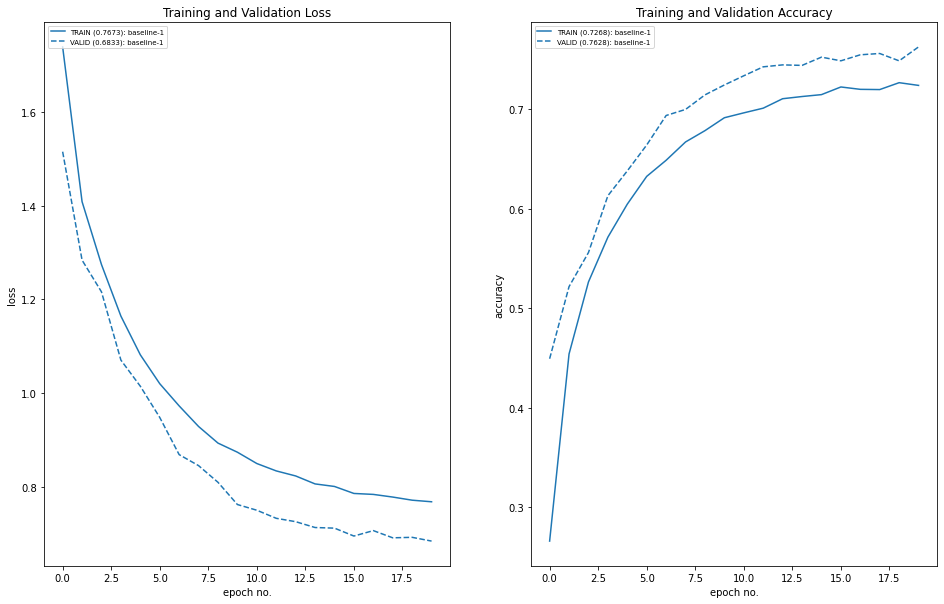

In [22]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["baseline-1"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

Application of transition block without max pool within each layer

In [111]:
class DialatedClassificationTransition(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_units,
        out_channels,
        multiplier_1=1,
        multiplier_2=2,
        dropout=0.1,
    ):
        super(DialatedClassificationTransition, self).__init__()
        # block1
        self.conv_bl1 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )
        # transition block
        self.transition = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=hidden_units,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            ),
        )
        # block2
        self.conv_bl2 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )
        # block3
        self.conv_bl3 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )
        # block4
        self.conv_bl4 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=out_channels,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            )
        )

    def forward(self, x):
        x = self.conv_bl1(x)
        x = self.transition(x)
        x = self.conv_bl2(x)
        x = self.transition(x)
        x = self.conv_bl3(x)
        x = self.transition(x)
        x = self.conv_bl4(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [112]:
# New Model Instance
baseline_model_2 = DialatedClassificationTransition(
    in_channels=3, hidden_units=16, out_channels=10, multiplier_1=2, multiplier_2=4
).to(device)
summary(baseline_model_2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          36,864
             ReLU-10           [-1, 64, 30, 30]               0
      BatchNorm2d-11           [-1, 64, 30, 30]             128
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 16, 30, 30]           1,024
           Conv2d-14           [-1, 32,

In [113]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)

In [114]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        baseline_model_2,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        baseline_model_2,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )
    early_stopping(
        test_losses[-1], baseline_model_2, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/391 [00:00<?, ?it/s]/

Avg Train Loss: 1.5334540078097292 Avg Train Metric: 0.345320156868309: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.00it/s]


Function Took 39.1134 seconds


Avg Test Loss: 1.3691822350779665 Avg Test Metric: 0.5193777423870715: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.41it/s]


Function Took 2.6019 seconds
Validation loss decreased (inf --> 1.369182).  Saving model ...
Epoch 1


Avg Train Loss: 1.1944199012368537 Avg Train Metric: 0.5537366903651401: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.97it/s]


Function Took 39.2306 seconds


Avg Test Loss: 1.1442353408547896 Avg Test Metric: 0.5896536270274392: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.03it/s]


Function Took 2.6350 seconds
Validation loss decreased (1.369182 --> 1.144235).  Saving model ...
Epoch 2


Avg Train Loss: 1.0578294192128779 Avg Train Metric: 0.6138292538845326: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.04it/s]


Function Took 38.9639 seconds


Avg Test Loss: 0.9661081961438626 Avg Test Metric: 0.662144781667975: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.45it/s]


Function Took 2.6861 seconds
Validation loss decreased (1.144235 --> 0.966108).  Saving model ...
Epoch 3


Avg Train Loss: 0.9704286590256654 Avg Train Metric: 0.6508292386598904: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.11it/s]


Function Took 38.6862 seconds


Avg Test Loss: 0.8821986030928696 Avg Test Metric: 0.6795803813994685: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.47it/s]


Function Took 2.5964 seconds
Validation loss decreased (0.966108 --> 0.882199).  Saving model ...
Epoch 4


Avg Train Loss: 0.9156775841932467 Avg Train Metric: 0.6720499512179733: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.99it/s]


Function Took 39.1444 seconds


Avg Test Loss: 0.8222594336618351 Avg Test Metric: 0.7108335630803169: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.02it/s]


Function Took 2.6372 seconds
Validation loss decreased (0.882199 --> 0.822259).  Saving model ...
Epoch 5


Avg Train Loss: 0.8658121065105624 Avg Train Metric: 0.695115482563253: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.13it/s]


Function Took 38.6212 seconds


Avg Test Loss: 0.772510640228851 Avg Test Metric: 0.719850900052469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.24it/s]


Function Took 2.6163 seconds
Validation loss decreased (0.822259 --> 0.772511).  Saving model ...
Epoch 6


Avg Train Loss: 0.8219308246432058 Avg Train Metric: 0.7074053273786365: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.14it/s]


Function Took 38.5477 seconds


Avg Test Loss: 0.7387162077276013 Avg Test Metric: 0.7371690658074391: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.85it/s]


Function Took 2.6508 seconds
Validation loss decreased (0.772511 --> 0.738716).  Saving model ...
Epoch 7


Avg Train Loss: 0.7910708675299154 Avg Train Metric: 0.7253111268553283: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.98it/s]


Function Took 39.1814 seconds


Avg Test Loss: 0.6700387397144414 Avg Test Metric: 0.7653778240650515: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.85it/s]


Function Took 2.6505 seconds
Validation loss decreased (0.738716 --> 0.670039).  Saving model ...
Epoch 8


Avg Train Loss: 0.7576365211735601 Avg Train Metric: 0.7299334507464142: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.07it/s]


Function Took 38.8186 seconds


Avg Test Loss: 0.6829417378087587 Avg Test Metric: 0.7595699595499642: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.24it/s]


Function Took 2.6169 seconds
EarlyStopping counter: 1 out of 3
Epoch 9


Avg Train Loss: 0.7316521965634183 Avg Train Metric: 0.7449854427896192: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.12it/s]


Function Took 38.6343 seconds


Avg Test Loss: 0.6553576049170916 Avg Test Metric: 0.7794946190677111: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.02it/s]


Function Took 2.6359 seconds
Validation loss decreased (0.670039 --> 0.655358).  Saving model ...
Epoch 10


Avg Train Loss: 0.7109290097680543 Avg Train Metric: 0.7549777378511551: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.03it/s]


Function Took 38.9728 seconds


Avg Test Loss: 0.5995035295999502 Avg Test Metric: 0.7985179876979394: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.89it/s]


Function Took 2.6473 seconds
Validation loss decreased (0.655358 --> 0.599504).  Saving model ...
Epoch 11


Avg Train Loss: 0.6839465649079179 Avg Train Metric: 0.7626233046012156: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.02it/s]


Function Took 39.0170 seconds


Avg Test Loss: 0.6036491212965567 Avg Test Metric: 0.7913950742045536: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.39it/s]


Function Took 2.6039 seconds
EarlyStopping counter: 1 out of 3
Epoch 12


Avg Train Loss: 0.6688820189984558 Avg Train Metric: 0.7675632971631902: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.17it/s]


Function Took 38.4570 seconds


Avg Test Loss: 0.5905909183659132 Avg Test Metric: 0.7926738367804999: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.97it/s]


Function Took 2.7312 seconds
Validation loss decreased (0.599504 --> 0.590591).  Saving model ...
Epoch 13


Avg Train Loss: 0.6555091997851497 Avg Train Metric: 0.7675027226852944: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.10it/s]


Function Took 38.7137 seconds


Avg Test Loss: 0.6158280063279068 Avg Test Metric: 0.7862893456145178: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.35it/s]


Function Took 2.6071 seconds
EarlyStopping counter: 1 out of 3
Epoch 14


Avg Train Loss: 0.6395338487899517 Avg Train Metric: 0.7751219670485963: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.15it/s]


Function Took 38.5326 seconds


Avg Test Loss: 0.5542773985410039 Avg Test Metric: 0.8129932548426375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.04it/s]


Function Took 2.6341 seconds
Validation loss decreased (0.590591 --> 0.554277).  Saving model ...
Epoch 15


Avg Train Loss: 0.6242173961208909 Avg Train Metric: 0.7846635078530177: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.17it/s]


Function Took 38.4507 seconds


Avg Test Loss: 0.5478627210176443 Avg Test Metric: 0.8156217698809467: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.88it/s]


Function Took 2.6481 seconds
Validation loss decreased (0.554277 --> 0.547863).  Saving model ...
Epoch 16


Avg Train Loss: 0.6131510124029711 Avg Train Metric: 0.788556972123168: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.13it/s]


Function Took 38.5855 seconds


Avg Test Loss: 0.5518971809858009 Avg Test Metric: 0.8227232543728019: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.23it/s]


Function Took 2.6173 seconds
EarlyStopping counter: 1 out of 3
Epoch 17


Avg Train Loss: 0.6008079321030766 Avg Train Metric: 0.793133149518991: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.01it/s]


Function Took 39.0768 seconds


Avg Test Loss: 0.5431304770179942 Avg Test Metric: 0.8189848812320565: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.98it/s]


Function Took 2.6389 seconds
Validation loss decreased (0.547863 --> 0.543130).  Saving model ...
Epoch 18


Avg Train Loss: 0.5912513961572476 Avg Train Metric: 0.7980418775392615: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.12it/s]


Function Took 38.6295 seconds


Avg Test Loss: 0.5195158493669727 Avg Test Metric: 0.8236444962175586: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.33it/s]


Function Took 2.6978 seconds
Validation loss decreased (0.543130 --> 0.519516).  Saving model ...
Epoch 19


Avg Train Loss: 0.5837522967697104 Avg Train Metric: 0.8000481444246629: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.12it/s]


Function Took 38.6270 seconds


Avg Test Loss: 0.5122019961664949 Avg Test Metric: 0.8230240797694726: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.75it/s]


Function Took 2.6602 seconds
Validation loss decreased (0.519516 --> 0.512202).  Saving model ...


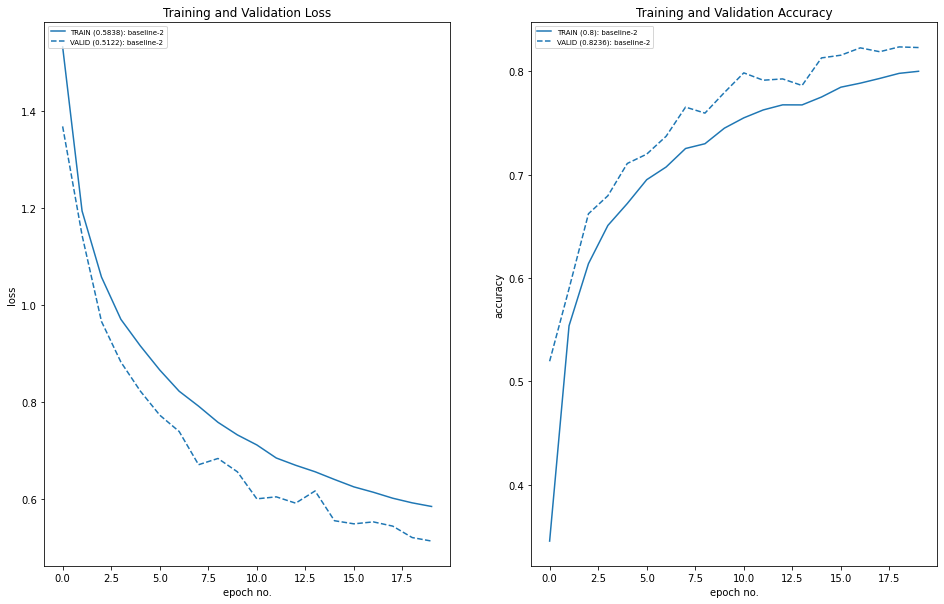

In [116]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["baseline-2"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

Application of LR scheduler

In [117]:
# New Model Instance
baseline_model_3 = DialatedClassificationTransition(
    in_channels=3, hidden_units=16, out_channels=10, multiplier_1=2, multiplier_2=4
).to(device)
summary(baseline_model_3, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          36,864
             ReLU-10           [-1, 64, 30, 30]               0
      BatchNorm2d-11           [-1, 64, 30, 30]             128
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 16, 30, 30]           1,024
           Conv2d-14           [-1, 32,

In [118]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_3.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)
# lr scheduler
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [119]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        baseline_model_3,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        baseline_model_3,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

    lr_scheduler.step()  # lr scheduler stepping
    print(f"For next epoch lr:: {lr_scheduler.get_last_lr()[0]}")
    early_stopping(
        test_losses[-1], baseline_model_3, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/391 [00:00<?, ?it/s]/

Avg Train Loss: 1.5282588514220683 Avg Train Metric: 0.3482717328783496: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.00it/s]


Function Took 39.1002 seconds


Avg Test Loss: 1.2309462594080576 Avg Test Metric: 0.5432434617718563: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.53it/s]


Function Took 2.7732 seconds
For next epoch lr:: 0.00095
Validation loss decreased (inf --> 1.230946).  Saving model ...
Epoch 1


Avg Train Loss: 1.1769590277196196 Avg Train Metric: 0.5605231342108353: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.93it/s]


Function Took 39.3667 seconds


Avg Test Loss: 0.9932337335393399 Avg Test Metric: 0.6351236746281008: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.59it/s]


Function Took 2.6738 seconds
For next epoch lr:: 0.0009025
Validation loss decreased (1.230946 --> 0.993234).  Saving model ...
Epoch 2


Avg Train Loss: 1.0461196571664737 Avg Train Metric: 0.6158637512675331: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.08it/s]


Function Took 38.7945 seconds


Avg Test Loss: 0.9037436673158332 Avg Test Metric: 0.6740649787685539: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.83it/s]


Function Took 2.6526 seconds
For next epoch lr:: 0.000857375
Validation loss decreased (0.993234 --> 0.903744).  Saving model ...
Epoch 3


Avg Train Loss: 0.9607737321987786 Avg Train Metric: 0.6532329267553051: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.96it/s]


Function Took 39.2616 seconds


Avg Test Loss: 0.848149753824065 Avg Test Metric: 0.6934137035019791: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.50it/s]


Function Took 2.6821 seconds
For next epoch lr:: 0.0008145062499999999
Validation loss decreased (0.903744 --> 0.848150).  Saving model ...
Epoch 4


Avg Train Loss: 0.908200681971772 Avg Train Metric: 0.6671725156362099: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.36it/s]


Function Took 41.7583 seconds


Avg Test Loss: 0.7809175637703908 Avg Test Metric: 0.7173272288298305: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.26it/s]


Function Took 2.7043 seconds
For next epoch lr:: 0.0007737809374999998
Validation loss decreased (0.848150 --> 0.780918).  Saving model ...
Epoch 5


Avg Train Loss: 0.8578350562268816 Avg Train Metric: 0.6934549857283492: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.14it/s]


Function Took 38.5542 seconds


Avg Test Loss: 0.7382694920407066 Avg Test Metric: 0.7452923700779299: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.33it/s]


Function Took 2.7927 seconds
For next epoch lr:: 0.0007350918906249997
Validation loss decreased (0.780918 --> 0.738269).  Saving model ...
Epoch 6


Avg Train Loss: 0.816066125927069 Avg Train Metric: 0.7163548897904204: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.71it/s]


Function Took 40.2753 seconds


Avg Test Loss: 0.7160326151908198 Avg Test Metric: 0.7606778688068632: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.55it/s]


Function Took 2.5898 seconds
For next epoch lr:: 0.0006983372960937497
Validation loss decreased (0.738269 --> 0.716033).  Saving model ...
Epoch 7


Avg Train Loss: 0.78133576498617 Avg Train Metric: 0.7265277192415789: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.77it/s]


Function Took 40.0111 seconds


Avg Test Loss: 0.6873875135862375 Avg Test Metric: 0.7648300898226001: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.13it/s]


Function Took 2.7159 seconds
For next epoch lr:: 0.0006634204312890621
Validation loss decreased (0.716033 --> 0.687388).  Saving model ...
Epoch 8


Avg Train Loss: 0.7498704502954507 Avg Train Metric: 0.7376135230979042: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.93it/s]


Function Took 39.3682 seconds


Avg Test Loss: 0.642616097685657 Avg Test Metric: 0.7749934966051126: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.47it/s]


Function Took 2.5967 seconds
For next epoch lr:: 0.000630249409724609
Validation loss decreased (0.687388 --> 0.642616).  Saving model ...
Epoch 9


Avg Train Loss: 0.7265419469160193 Avg Train Metric: 0.7444216482474676: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.97it/s]


Function Took 39.2039 seconds


Avg Test Loss: 0.6097097004516215 Avg Test Metric: 0.7816547313822976: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.95it/s]


Function Took 2.7333 seconds
For next epoch lr:: 0.0005987369392383785
Validation loss decreased (0.642616 --> 0.609710).  Saving model ...
Epoch 10


Avg Train Loss: 0.6971677068401786 Avg Train Metric: 0.7528118241168654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.04it/s]


Function Took 38.9392 seconds


Avg Test Loss: 0.6208093626589715 Avg Test Metric: 0.7753307442121868: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.54it/s]


Function Took 2.5905 seconds
For next epoch lr:: 0.0005688000922764595
EarlyStopping counter: 1 out of 3
Epoch 11


Avg Train Loss: 0.6824841915494035 Avg Train Metric: 0.7663721980341255: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.13it/s]


Function Took 38.5871 seconds


Avg Test Loss: 0.5863341375996795 Avg Test Metric: 0.7976580541345137: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.16it/s]


Function Took 2.6236 seconds
For next epoch lr:: 0.0005403600876626365
Validation loss decreased (0.609710 --> 0.586334).  Saving model ...
Epoch 12


Avg Train Loss: 0.6592914208274363 Avg Train Metric: 0.7703597893190506: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.00it/s]


Function Took 39.1149 seconds


Avg Test Loss: 0.5589668279207205 Avg Test Metric: 0.8063204409200934: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.55it/s]


Function Took 2.5894 seconds
For next epoch lr:: 0.0005133420832795047
Validation loss decreased (0.586334 --> 0.558967).  Saving model ...
Epoch 13


Avg Train Loss: 0.6475284725351407 Avg Train Metric: 0.7729393649284187: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.17it/s]


Function Took 38.4333 seconds


Avg Test Loss: 0.5688639315246027 Avg Test Metric: 0.7997022346605228: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.14it/s]


Function Took 2.5412 seconds
For next epoch lr:: 0.00048767497911552944
EarlyStopping counter: 1 out of 3
Epoch 14


Avg Train Loss: 0.6255835252802086 Avg Train Metric: 0.7829026050884705: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00, 10.01it/s]


Function Took 39.0501 seconds


Avg Test Loss: 0.5586902435067334 Avg Test Metric: 0.8101277328744719: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.34it/s]


Function Took 2.6074 seconds
For next epoch lr:: 0.00046329123015975297
Validation loss decreased (0.558967 --> 0.558690).  Saving model ...
Epoch 15


Avg Train Loss: 0.607349965197351 Avg Train Metric: 0.784258686977884: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.09it/s]


Function Took 38.7550 seconds


Avg Test Loss: 0.5149698317805423 Avg Test Metric: 0.8229778952236417: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.20it/s]


Function Took 2.6201 seconds
For next epoch lr:: 0.0004401266686517653
Validation loss decreased (0.558690 --> 0.514970).  Saving model ...
Epoch 16


Avg Train Loss: 0.6041832579218823 Avg Train Metric: 0.7901625153048873: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.75it/s]


Function Took 40.1102 seconds


Avg Test Loss: 0.5103524632846252 Avg Test Metric: 0.8216625142701065: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.83it/s]


Function Took 2.7443 seconds
For next epoch lr:: 0.00041812033521917703
Validation loss decreased (0.514970 --> 0.510352).  Saving model ...
Epoch 17


Avg Train Loss: 0.5853301157884281 Avg Train Metric: 0.7976742964571394: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.90it/s]


Function Took 39.5107 seconds


Avg Test Loss: 0.5126765061028397 Avg Test Metric: 0.8256248016900654: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.34it/s]


Function Took 2.6967 seconds
For next epoch lr:: 0.00039721431845821814
EarlyStopping counter: 1 out of 3
Epoch 18


Avg Train Loss: 0.5766843467417275 Avg Train Metric: 0.798927943877247: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.63it/s]


Function Took 40.5917 seconds


Avg Test Loss: 0.5047116034393069 Avg Test Metric: 0.8326457022111627: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 25.57it/s]


Function Took 3.0933 seconds
For next epoch lr:: 0.0003773536025353072
Validation loss decreased (0.510352 --> 0.504712).  Saving model ...
Epoch 19


Avg Train Loss: 0.5673255238234235 Avg Train Metric: 0.8001269205756809: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.92it/s]


Function Took 39.4216 seconds


Avg Test Loss: 0.4936582491367678 Avg Test Metric: 0.8361358921739119: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.40it/s]


Function Took 2.6912 seconds
For next epoch lr:: 0.0003584859224085418
Validation loss decreased (0.504712 --> 0.493658).  Saving model ...


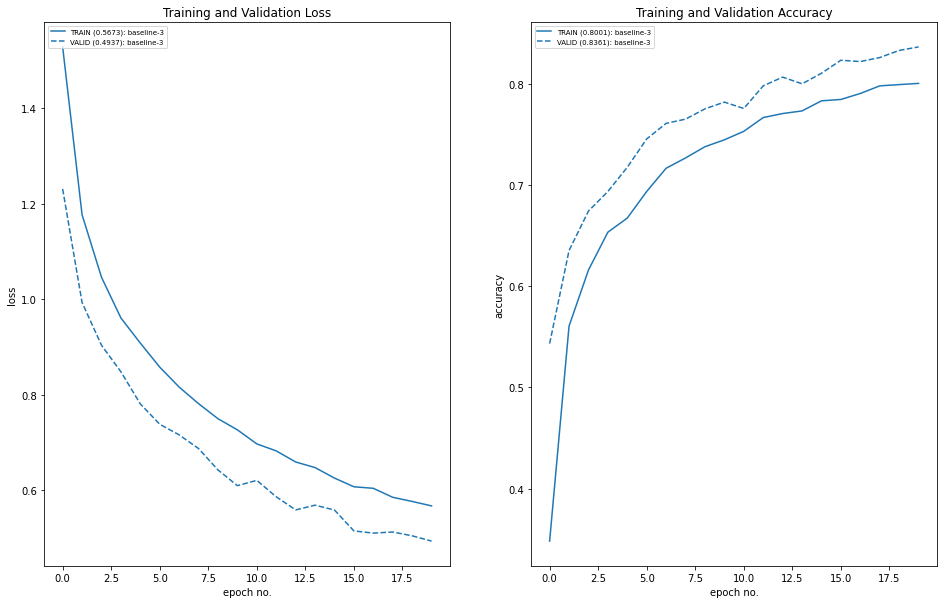

In [120]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["baseline-3"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

### Addition of Depth wise Seperable convolution 

In [55]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(
            nin, kernels_per_layer, kernel_size=3, padding=1, groups=nin
        )
        self.pointwise = nn.Conv2d(kernels_per_layer, nout, kernel_size=1) # always 1

    def forward(self, x):
        out = self.depthwise(x)
        print(out.shape)
        out = self.pointwise(out)
        print(out.shape)
        return out

In [56]:
depth_conv = depthwise_separable_conv(3, 3, 10).to(device)
summary(depth_conv, input_size=(3, 32, 32))

torch.Size([2, 3, 32, 32])
torch.Size([2, 10, 32, 32])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              30
            Conv2d-2           [-1, 10, 32, 32]              40
Total params: 70
Trainable params: 70
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.00
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [59]:
class DepthwiseSeparableClassifier(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_units,
        out_channels,
        multiplier_1=1,
        multiplier_2=2,
        dropout=0.1,
    ):
        super(DepthwiseSeparableClassifier, self).__init__()
        # block1
        self.conv_bl1 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )
        # transition block
        self.transition = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            ),
        )
        # block2
        self.conv_bl2 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )
        # block3
        self.conv_bl3 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.Dropout(dropout),
        )
        # block4 - Depthwise Separable Convolution **
        self.conv_bl4 = nn.Sequential(
            # set1
            # depthwise
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=multiplier_1 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            # depthwise
            nn.Conv2d(
                in_channels=(multiplier_1 * hidden_units),
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=multiplier_1 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),

            # set3 -non-dialation
            # depthwise
            nn.Conv2d(
                in_channels=(multiplier_2 * hidden_units),
                out_channels=multiplier_2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=multiplier_2 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=multiplier_2 * hidden_units,
                out_channels=multiplier_1 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(multiplier_1 * hidden_units),
            nn.ReLU(),
        )


        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=multiplier_1 * hidden_units,
                out_channels=out_channels,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            )
        )

    def forward(self, x):
        x = self.conv_bl1(x)
        x = self.transition(x)
        x = self.conv_bl2(x)
        x = self.transition(x)
        x = self.conv_bl3(x)
        x = self.transition(x)
        x = self.conv_bl4(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [66]:
# New Model Instance
depthwise_model1 = DepthwiseSeparableClassifier(
    in_channels=3, hidden_units=16, out_channels=10, multiplier_1=2, multiplier_2=6
).to(device)
summary(depthwise_model1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 96, 32, 32]          27,648
              ReLU-6           [-1, 96, 32, 32]               0
       BatchNorm2d-7           [-1, 96, 32, 32]             192
           Dropout-8           [-1, 96, 32, 32]               0
            Conv2d-9           [-1, 32, 30, 30]          27,648
             ReLU-10           [-1, 32, 30, 30]               0
      BatchNorm2d-11           [-1, 32, 30, 30]              64
          Dropout-12           [-1, 32, 30, 30]               0
           Conv2d-13           [-1, 32, 30, 30]           1,024
           Conv2d-14           [-1, 32,

In [67]:
# driver setup----
# optmizer
optimizer = optim.Adam(depthwise_model1.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)
# lr scheduler
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [69]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        depthwise_model1,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        depthwise_model1,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

    lr_scheduler.step()  # lr scheduler stepping
    print(f"For next epoch lr:: {lr_scheduler.get_last_lr()[0]}")
    early_stopping(
        test_losses[-1], depthwise_model1, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/391 [00:00<?, ?it/s]/

Function Took 42.1687 seconds


Avg Test Loss: 1.3974654855607431 Avg Test Metric: 0.46823732573774796: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.65it/s]


Function Took 2.6688 seconds
For next epoch lr:: 0.00095
Validation loss decreased (inf --> 1.397465).  Saving model ...
Epoch 1


Avg Train Loss: 1.263569650747587 Avg Train Metric: 0.5252469474702235: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.44it/s]


Function Took 41.4146 seconds


Avg Test Loss: 1.1419765715357624 Avg Test Metric: 0.5806797010989129: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.41it/s]


Function Took 2.5191 seconds
For next epoch lr:: 0.0009025
Validation loss decreased (1.397465 --> 1.141977).  Saving model ...
Epoch 2


Avg Train Loss: 1.1058814426517243 Avg Train Metric: 0.5945779463214338: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.31it/s]


Function Took 42.0233 seconds


Avg Test Loss: 0.9503646364694909 Avg Test Metric: 0.657331515716601: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.05it/s]


Function Took 2.7233 seconds
For next epoch lr:: 0.000857375
Validation loss decreased (1.141977 --> 0.950365).  Saving model ...
Epoch 3


Avg Train Loss: 1.0161511134308623 Avg Train Metric: 0.6310057548610756: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.18it/s]


Function Took 42.5868 seconds


Avg Test Loss: 0.8831103323381159 Avg Test Metric: 0.6848764759075793: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.37it/s]


Function Took 2.6055 seconds
For next epoch lr:: 0.0008145062499999999
Validation loss decreased (0.950365 --> 0.883110).  Saving model ...
Epoch 4


Avg Train Loss: 0.9478107294463136 Avg Train Metric: 0.659164242884692: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:43<00:00,  9.08it/s]


Function Took 43.0816 seconds


Avg Test Loss: 0.8900423351722427 Avg Test Metric: 0.6828662549393086: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.84it/s]


Function Took 2.6522 seconds
For next epoch lr:: 0.0007737809374999998
EarlyStopping counter: 1 out of 3
Epoch 5


Avg Train Loss: 0.9013430736863705 Avg Train Metric: 0.6719453612251964: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.31it/s]


Function Took 42.0088 seconds


Avg Test Loss: 0.7769840804836418 Avg Test Metric: 0.7258810212340536: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.37it/s]


Function Took 2.6941 seconds
For next epoch lr:: 0.0007350918906249997
Validation loss decreased (0.883110 --> 0.776984).  Saving model ...
Epoch 6


Avg Train Loss: 0.8583989780577247 Avg Train Metric: 0.6987127489446069: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.16it/s]


Function Took 42.6893 seconds


Avg Test Loss: 0.7650435212292249 Avg Test Metric: 0.7333287332631364: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.28it/s]


Function Took 2.6131 seconds
For next epoch lr:: 0.0006983372960937497
Validation loss decreased (0.776984 --> 0.765044).  Saving model ...
Epoch 7


Avg Train Loss: 0.8252802674117905 Avg Train Metric: 0.7102255586468046: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.36it/s]


Function Took 41.7703 seconds


Avg Test Loss: 0.7186319450788861 Avg Test Metric: 0.749258885655222: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.04it/s]


Function Took 2.6335 seconds
For next epoch lr:: 0.0006634204312890621
Validation loss decreased (0.765044 --> 0.718632).  Saving model ...
Epoch 8


Avg Train Loss: 0.7888132381012373 Avg Train Metric: 0.7192150727867166: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.29it/s]


Function Took 42.1107 seconds


Avg Test Loss: 0.6952868149250369 Avg Test Metric: 0.759440995469878: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.62it/s]


Function Took 2.5848 seconds
For next epoch lr:: 0.000630249409724609
Validation loss decreased (0.718632 --> 0.695287).  Saving model ...
Epoch 9


Avg Train Loss: 0.7556223927251519 Avg Train Metric: 0.7337185927973989: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.32it/s]


Function Took 41.9496 seconds


Avg Test Loss: 0.6801485804062856 Avg Test Metric: 0.7602389552925206: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.74it/s]


Function Took 2.5740 seconds
For next epoch lr:: 0.0005987369392383785
Validation loss decreased (0.695287 --> 0.680149).  Saving model ...
Epoch 10


Avg Train Loss: 0.7308768773322825 Avg Train Metric: 0.7456908562909002: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.40it/s]


Function Took 41.5934 seconds


Avg Test Loss: 0.6628687393061722 Avg Test Metric: 0.7690258916420273: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.09it/s]


Function Took 2.5450 seconds
For next epoch lr:: 0.0005688000922764595
Validation loss decreased (0.680149 --> 0.662869).  Saving model ...
Epoch 11


Avg Train Loss: 0.7159142629112429 Avg Train Metric: 0.7465199361676755: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.33it/s]


Function Took 41.9021 seconds


Avg Test Loss: 0.6218197541900828 Avg Test Metric: 0.7817081839223451: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.63it/s]


Function Took 2.5830 seconds
For next epoch lr:: 0.0005403600876626365
Validation loss decreased (0.662869 --> 0.621820).  Saving model ...
Epoch 12


Avg Train Loss: 0.687320645203066 Avg Train Metric: 0.7597292626605314: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.42it/s]


Function Took 41.5310 seconds


Avg Test Loss: 0.5867788829380953 Avg Test Metric: 0.7913828160189376: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.83it/s]


Function Took 2.5664 seconds
For next epoch lr:: 0.0005133420832795047
Validation loss decreased (0.621820 --> 0.586779).  Saving model ...
Epoch 13


Avg Train Loss: 0.6735533766277001 Avg Train Metric: 0.7591365289200297: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.39it/s]


Function Took 41.6559 seconds


Avg Test Loss: 0.5783911600143095 Avg Test Metric: 0.8027763351609435: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.25it/s]


Function Took 2.5320 seconds
For next epoch lr:: 0.00048767497911552944
Validation loss decreased (0.586779 --> 0.578391).  Saving model ...
Epoch 14


Avg Train Loss: 0.6599441137917511 Avg Train Metric: 0.7708829156578044: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.42it/s]


Function Took 41.4920 seconds


Avg Test Loss: 0.5607266192194782 Avg Test Metric: 0.8077131607864476: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.51it/s]


Function Took 2.5111 seconds
For next epoch lr:: 0.00046329123015975297
Validation loss decreased (0.578391 --> 0.560727).  Saving model ...
Epoch 15


Avg Train Loss: 0.6481048012785899 Avg Train Metric: 0.775738274959652: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.37it/s]


Function Took 41.7356 seconds


Avg Test Loss: 0.5452327626415446 Avg Test Metric: 0.8145855604847775: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.05it/s]


Function Took 2.6333 seconds
For next epoch lr:: 0.0004401266686517653
Validation loss decreased (0.560727 --> 0.545233).  Saving model ...
Epoch 16


Avg Train Loss: 0.6252431405322326 Avg Train Metric: 0.7820883745427631: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.35it/s]


Function Took 41.8402 seconds


Avg Test Loss: 0.5555268314820302 Avg Test Metric: 0.8131575833393049: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 30.49it/s]


Function Took 2.5953 seconds
For next epoch lr:: 0.00041812033521917703
EarlyStopping counter: 1 out of 3
Epoch 17


Avg Train Loss: 0.6178332521482501 Avg Train Metric: 0.7834465680524821: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.47it/s]


Function Took 41.2720 seconds


Avg Test Loss: 0.5329585362084305 Avg Test Metric: 0.8180881406687484: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.75it/s]


Function Took 2.6597 seconds
For next epoch lr:: 0.00039721431845821814
Validation loss decreased (0.545233 --> 0.532959).  Saving model ...
Epoch 18


Avg Train Loss: 0.6070440702731043 Avg Train Metric: 0.7854715180214104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.39it/s]


Function Took 41.6563 seconds


Avg Test Loss: 0.5272001609017577 Avg Test Metric: 0.8158460357521153: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.86it/s]


Function Took 2.6494 seconds
For next epoch lr:: 0.0003773536025353072
Validation loss decreased (0.532959 --> 0.527200).  Saving model ...
Epoch 19


Avg Train Loss: 0.5916293027913174 Avg Train Metric: 0.793478090439916: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.35it/s]


Function Took 41.8381 seconds


Avg Test Loss: 0.5228750369971311 Avg Test Metric: 0.8161795244941229: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.58it/s]


Function Took 2.6746 seconds
For next epoch lr:: 0.0003584859224085418
Validation loss decreased (0.527200 --> 0.522875).  Saving model ...


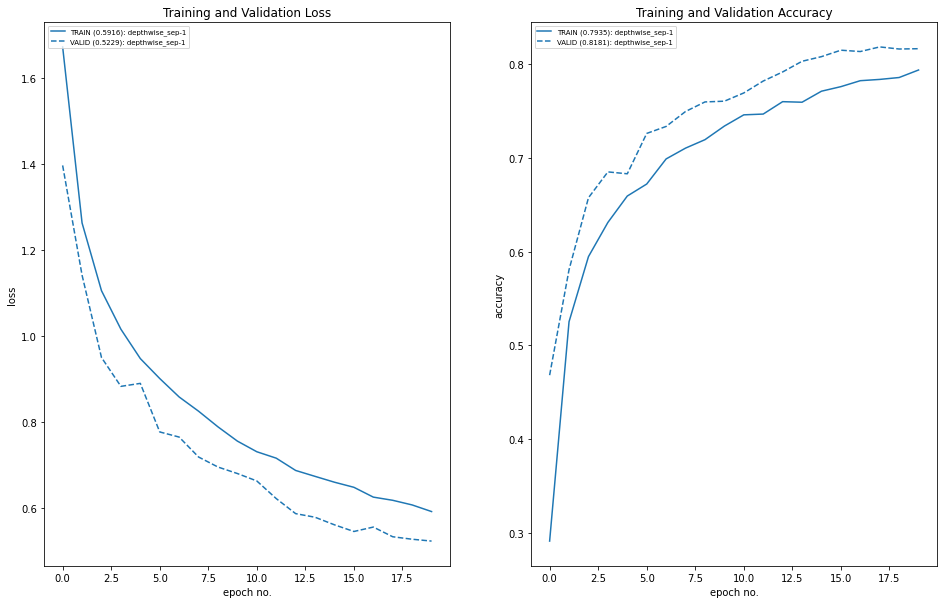

In [71]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["depthwise_sep-1"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

Another model with hardcoded multiplier values (2,3,4)

In [101]:
class DepthwiseSeparableClassifierSync(nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_units,
        out_channels,
        dropout=0.1,
    ):
        super(DepthwiseSeparableClassifierSync, self).__init__()
        # block1
        self.conv_bl1 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),

            # set3 -dialation
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
        )
        # transition block
        self.transition = nn.Sequential(
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=hidden_units,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            ),
        )
        # block2
        self.conv_bl2 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
        )
        # block3
        self.conv_bl3 = nn.Sequential(
            # set1
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
            # set3 -dialation
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                dilation=2,  # application of dialated convolution
                bias=False,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(4 * hidden_units),
            nn.Dropout(dropout),
        )
        # block4 - Depthwise Separable Convolution **
        self.conv_bl4 = nn.Sequential(
            # set1
            # depthwise
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=2 * hidden_units,
                out_channels=2 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(2 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set2
            # depthwise
            nn.Conv2d(
                in_channels=(2 * hidden_units),
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=2 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(4 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            # set3 -non-dialation - depthwise
            # depthwise
            nn.Conv2d(
                in_channels=(4 * hidden_units),
                out_channels=4 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=4 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=4 * hidden_units,
                out_channels=4  * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(4 * hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout),

            #set4- expansion
            # depthwise
            nn.Conv2d(
                in_channels=(4 * hidden_units),
                out_channels=8 * hidden_units,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
                groups=4 * hidden_units,
            ),
            # pointwise
            nn.Conv2d(
                in_channels=8 * hidden_units,
                out_channels=8 * hidden_units,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(8 * hidden_units),
            nn.ReLU(),

        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=8 * hidden_units,
                out_channels=out_channels,
                kernel_size=(1, 1),
                padding=0,
                bias=False,
            )
        )

    def forward(self, x):
        x = self.conv_bl1(x)
        x = self.transition(x)
        x = self.conv_bl2(x)
        x = self.transition(x)
        x = self.conv_bl3(x)
        x = self.transition(x)
        x = self.conv_bl4(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [102]:
# New Model Instance
depthwise_model2 = DepthwiseSeparableClassifierSync(
    in_channels=3, hidden_units=16, out_channels=10
).to(device)
summary(depthwise_model2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 30, 30]          36,864
             ReLU-10           [-1, 64, 30, 30]               0
      BatchNorm2d-11           [-1, 64, 30, 30]             128
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 16, 30, 30]           1,024
           Conv2d-14           [-1, 32,

In [104]:
# driver setup----
# optmizer
optimizer = optim.Adam(depthwise_model2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device=device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=3, verbose=True)
# lr scheduler
lr_scheduler = ExponentialLR(optimizer, gamma=0.97)

In [105]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        depthwise_model2,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        depthwise_model2,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

    lr_scheduler.step()  # lr scheduler stepping
    print(f"For next epoch lr:: {lr_scheduler.get_last_lr()[0]}")
    early_stopping(
        test_losses[-1], depthwise_model2, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/391 [00:00<?, ?it/s]/

Avg Train Loss: 1.591092801764798 Avg Train Metric: 0.3171818989622014: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.42it/s]


Function Took 41.4921 seconds


Avg Test Loss: 1.3053188776668114 Avg Test Metric: 0.5065686819674093: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.72it/s]


Function Took 2.7543 seconds
For next epoch lr:: 0.0009699999999999999
Validation loss decreased (inf --> 1.305319).  Saving model ...
Epoch 1


Avg Train Loss: 1.2501024571830963 Avg Train Metric: 0.5181429074395953: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.33it/s]


Function Took 41.8986 seconds


Avg Test Loss: 1.1513444388969034 Avg Test Metric: 0.5768417799020116: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.31it/s]


Function Took 2.7946 seconds
For next epoch lr:: 0.0009408999999999999
Validation loss decreased (1.305319 --> 1.151344).  Saving model ...
Epoch 2


Avg Train Loss: 1.1012683920848094 Avg Train Metric: 0.5934900521012523: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.53it/s]


Function Took 41.0479 seconds


Avg Test Loss: 0.9993647872647152 Avg Test Metric: 0.6438168392905707: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.11it/s]


Function Took 2.7179 seconds
For next epoch lr:: 0.0009126729999999999
Validation loss decreased (1.151344 --> 0.999365).  Saving model ...
Epoch 3


Avg Train Loss: 1.0120673790917067 Avg Train Metric: 0.6349182215797932: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.45it/s]


Function Took 41.3605 seconds


Avg Test Loss: 0.9551246981077557 Avg Test Metric: 0.6548411559455002: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.35it/s]


Function Took 2.6958 seconds
For next epoch lr:: 0.0008852928099999999
Validation loss decreased (0.999365 --> 0.955125).  Saving model ...
Epoch 4


Avg Train Loss: 0.9480915084824233 Avg Train Metric: 0.6529643206340273: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.44it/s]


Function Took 41.4287 seconds


Avg Test Loss: 0.8830392473860632 Avg Test Metric: 0.6937780946115905: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.48it/s]


Function Took 2.6834 seconds
For next epoch lr:: 0.0008587340256999998
Validation loss decreased (0.955125 --> 0.883039).  Saving model ...
Epoch 5


Avg Train Loss: 0.8937083275421805 Avg Train Metric: 0.6735763598585982: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.44it/s]


Function Took 41.4377 seconds


Avg Test Loss: 0.8285574015182785 Avg Test Metric: 0.7146446931211254: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 26.47it/s]


Function Took 2.9888 seconds
For next epoch lr:: 0.0008329720049289999
Validation loss decreased (0.883039 --> 0.828557).  Saving model ...
Epoch 6


Avg Train Loss: 0.8460737776268473 Avg Train Metric: 0.6950110793113708: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.45it/s]


Function Took 41.3914 seconds


Avg Test Loss: 0.7599479918238483 Avg Test Metric: 0.7391021229043792: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.04it/s]


Function Took 2.8221 seconds
For next epoch lr:: 0.0008079828447811299
Validation loss decreased (0.828557 --> 0.759948).  Saving model ...
Epoch 7


Avg Train Loss: 0.8089135557489322 Avg Train Metric: 0.7132799910462421: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.18it/s]


Function Took 42.6025 seconds


Avg Test Loss: 0.6816193570819082 Avg Test Metric: 0.76159317055835: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.67it/s]


Function Took 2.7592 seconds
For next epoch lr:: 0.0007837433594376959
Validation loss decreased (0.759948 --> 0.681619).  Saving model ...
Epoch 8


Avg Train Loss: 0.7746436233105867 Avg Train Metric: 0.723280311088123: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.35it/s]


Function Took 41.8133 seconds


Avg Test Loss: 0.669932519333272 Avg Test Metric: 0.7640203893939151: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 27.65it/s]


Function Took 2.8610 seconds
For next epoch lr:: 0.000760231058654565
Validation loss decreased (0.681619 --> 0.669933).  Saving model ...
Epoch 9


Avg Train Loss: 0.7439786777319506 Avg Train Metric: 0.738206943892457: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:42<00:00,  9.28it/s]


Function Took 42.1212 seconds


Avg Test Loss: 0.6420095400719703 Avg Test Metric: 0.7784052747714368: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 26.51it/s]


Function Took 2.9843 seconds
For next epoch lr:: 0.000737424126894928
Validation loss decreased (0.669933 --> 0.642010).  Saving model ...
Epoch 10


Avg Train Loss: 0.7247757546584624 Avg Train Metric: 0.7401695722509223: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.40it/s]


Function Took 41.5936 seconds


Avg Test Loss: 0.6817347214946264 Avg Test Metric: 0.7747835803635513: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.76it/s]


Function Took 2.7513 seconds
For next epoch lr:: 0.0007153014030880802
EarlyStopping counter: 1 out of 3
Epoch 11


Avg Train Loss: 0.695854400810988 Avg Train Metric: 0.756983214174695: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.47it/s]


Function Took 41.3028 seconds


Avg Test Loss: 0.6120442408549635 Avg Test Metric: 0.792592652236359: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.56it/s]


Function Took 2.7704 seconds
For next epoch lr:: 0.0006938423609954377
Validation loss decreased (0.642010 --> 0.612044).  Saving model ...
Epoch 12


Avg Train Loss: 0.6787744599687474 Avg Train Metric: 0.7634023159666135: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.42it/s]


Function Took 41.5310 seconds


Avg Test Loss: 0.5759346488910385 Avg Test Metric: 0.8092698545395574: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.73it/s]


Function Took 2.7536 seconds
For next epoch lr:: 0.0006730270901655745
Validation loss decreased (0.612044 --> 0.575935).  Saving model ...
Epoch 13


Avg Train Loss: 0.6572836962959651 Avg Train Metric: 0.7689859618616226: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.47it/s]


Function Took 41.2930 seconds


Avg Test Loss: 0.5864844782442986 Avg Test Metric: 0.7937326551992682: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.07it/s]


Function Took 2.8190 seconds
For next epoch lr:: 0.0006528362774606073
EarlyStopping counter: 1 out of 3
Epoch 14


Avg Train Loss: 0.6372474792515835 Avg Train Metric: 0.7799021601676941: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.43it/s]


Function Took 41.4500 seconds


Avg Test Loss: 0.5632749411124217 Avg Test Metric: 0.8062742578832409: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.48it/s]


Function Took 2.7774 seconds
For next epoch lr:: 0.0006332511891367891
Validation loss decreased (0.575935 --> 0.563275).  Saving model ...
Epoch 15


Avg Train Loss: 0.6250106921738676 Avg Train Metric: 0.7853188718981146: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.35it/s]


Function Took 41.8397 seconds


Avg Test Loss: 0.5363807025589521 Avg Test Metric: 0.8137839481800417: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.30it/s]


Function Took 2.7949 seconds
For next epoch lr:: 0.0006142536534626854
Validation loss decreased (0.563275 --> 0.536381).  Saving model ...
Epoch 16


Avg Train Loss: 0.6078930611500655 Avg Train Metric: 0.7899879563190139: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.38it/s]


Function Took 41.6910 seconds


Avg Test Loss: 0.5255904567392566 Avg Test Metric: 0.8206471408469768: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.76it/s]


Function Took 2.7502 seconds
For next epoch lr:: 0.0005958260438588048
Validation loss decreased (0.536381 --> 0.525590).  Saving model ...
Epoch 17


Avg Train Loss: 0.5971316130417387 Avg Train Metric: 0.7930369825314378: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.46it/s]


Function Took 41.3407 seconds


Avg Test Loss: 0.5415250606174711 Avg Test Metric: 0.8173898888539665: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.61it/s]


Function Took 2.7648 seconds
For next epoch lr:: 0.0005779512625430406
EarlyStopping counter: 1 out of 3
Epoch 18


Avg Train Loss: 0.584772248707159 Avg Train Metric: 0.7953393523345518: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.49it/s]


Function Took 41.2253 seconds


Avg Test Loss: 0.5436204996290086 Avg Test Metric: 0.8060053262529494: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.02it/s]


Function Took 2.7259 seconds
For next epoch lr:: 0.0005606127246667494
EarlyStopping counter: 2 out of 3
Epoch 19


Avg Train Loss: 0.5794426907053993 Avg Train Metric: 0.8010267366838577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:41<00:00,  9.43it/s]


Function Took 41.4543 seconds


Avg Test Loss: 0.49355840305738813 Avg Test Metric: 0.8391348206544225: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.19it/s]


Function Took 2.8061 seconds
For next epoch lr:: 0.0005437943429267469
Validation loss decreased (0.525590 --> 0.493558).  Saving model ...


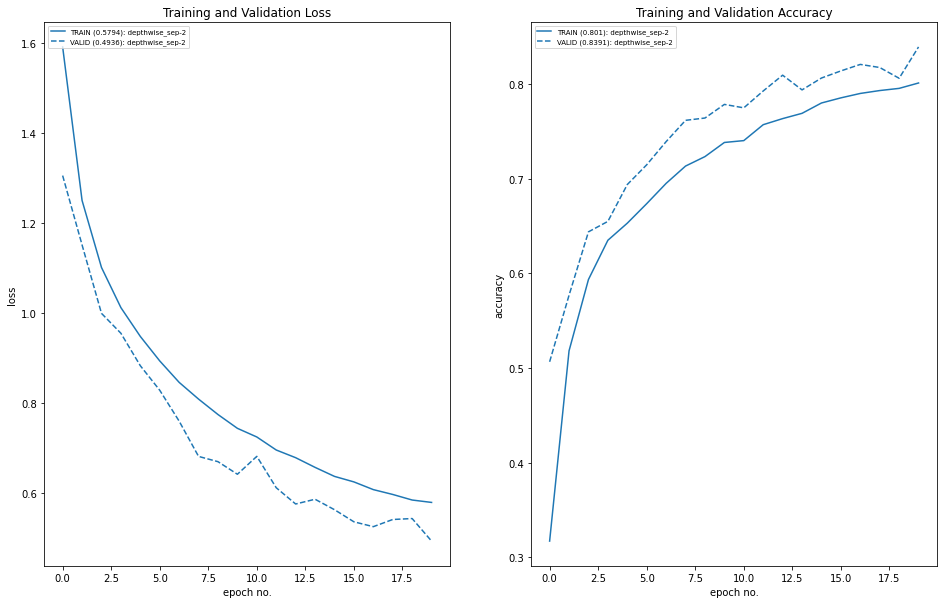

In [108]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["depthwise_sep-2"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)